In [16]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [17]:
# Cargamos el archivo
file = pd.read_csv('cwurData.csv')# ya regresa un dataframe 
""""#paises = file.loc[:,'influence']

###########
repetido = []
unico = []

 

for x in paises:

	if x not in unico:

		unico.append(x)

	else:

		if x not in repetido:

			repetido.append(x)

            
            
print (len(repetido))

print (len(unico))"""
file.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012



# Metodo de filtrado con datos numéricos

No es necesario filtrar los variables en este metodo, debido a que la correlacion solo toma en cuenta las caracteristicas que tiene valor numerico


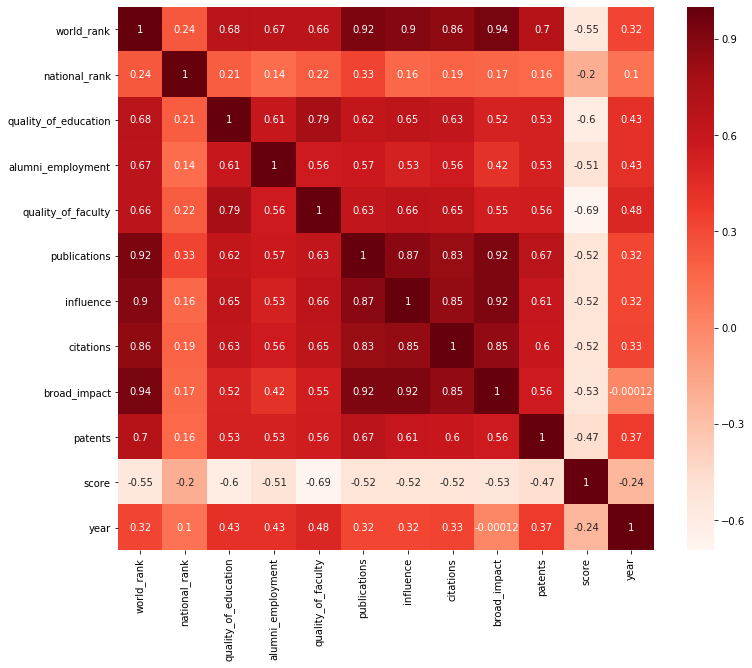

In [18]:
# Genereamos el mapa de calor de la correlacion entre las caracteristicas
plt.figure(figsize=(12,10))
cor = file.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


### Caracteristicas que tienen una correlacion mayor a 0.5 respecto a la influencia que tiene cada universidad


In [19]:
#correlacio respecto a la variable influence 
cor_target = abs(cor["influence"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

world_rank              0.895871
quality_of_education    0.645641
alumni_employment       0.527382
quality_of_faculty      0.656406
publications            0.874952
influence               1.000000
citations               0.845207
broad_impact            0.916040
patents                 0.611811
score                   0.522837
Name: influence, dtype: float64

Son muchas caracteristicas las que estan intimamente relacionadas con nuestra variable "influence" por lo que hay que ver cuales de ellas estan descorrelacionadas, es decir, que sean linealmente independentientes entre ellas.


In [21]:
# Nombre de las caracteristicas del DataFrame (correlacion >0.5 )
features = list(file)
features.remove("year")
features.remove("institution")
features.remove("country") 
features.remove("national_rank")
features.remove("influence") #Target

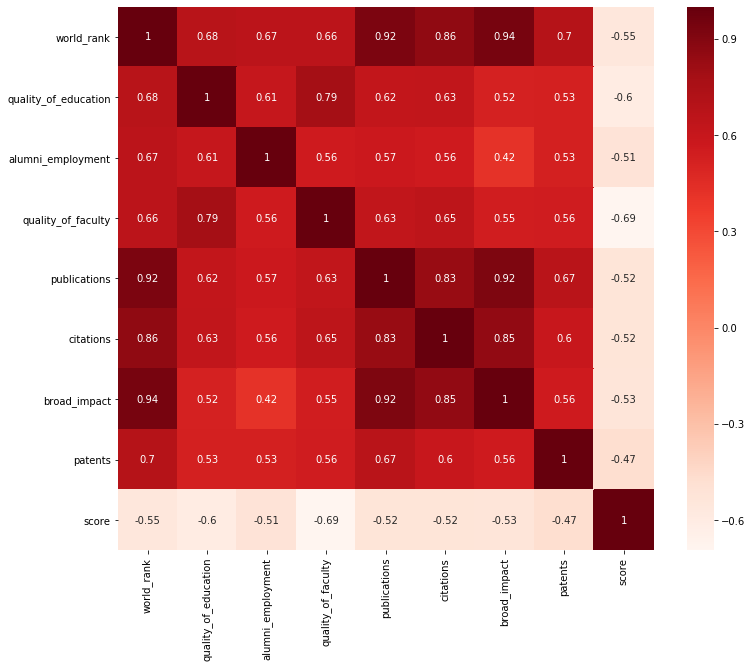

In [22]:
# Genereamos el mapa de calor de la correlacion entre las caracteristicas
plt.figure(figsize=(12,10))
cor = file[features].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


# Metodo de envoltura

In [23]:
# Eliminamos las columnas con variables categoricas del dataframe 
df = file.drop(columns =["institution","country","broad_impact"])
df.head()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,patents,score,year
0,1,1,7,9,1,1,1,1,5,100.00,2012
1,2,2,9,17,3,12,4,4,1,91.67,2012
2,3,3,17,11,5,4,2,2,15,89.50,2012
3,4,1,10,24,4,16,16,11,50,86.17,2012
4,5,4,2,29,7,37,22,22,18,85.21,2012


In [24]:
# Eliminamos la variable que queremos predecir
X = df.drop("influence",1) #Caracteristicas
Y = df["influence"] #target

In [25]:
#Backward Elimination
cols = list(X)

In [26]:
while(len(cols)>0):
    p=[]
    X_1 = X[cols]
    
    #Agregamos una clumna constante de unos
    X_1 = sm.add_constant(X_1)
        
    #Ajuste del modelo sm.OLS
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    features_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(features_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['world_rank', 'national_rank', 'quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications', 'citations', 'patents', 'year']


C:\Users\mrchu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## METODO DE ELIMINACION RECURSIVA


In [27]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,Y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[ True  True False False  True  True  True False  True  True]
[1 1 3 2 1 1 1 4 1 1]


In [28]:
#Número de características
nof_list = np.arange(1,len(X.columns))            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    #test_size = porcentage de datos para el entreamiento del modelo
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 8
Desempeño con 8 características: 0.859927


In [29]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['world_rank', 'national_rank', 'alumni_employment',
       'quality_of_faculty', 'publications', 'citations', 'score', 'year'],
      dtype='object')


## Embedded Method

In [30]:
reg = LassoCV()
reg.fit(X, Y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,Y))

Número óptimo de características:8
Desempeño mediante la regularización Lasso: 0.854847


C:\Users\mrchu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

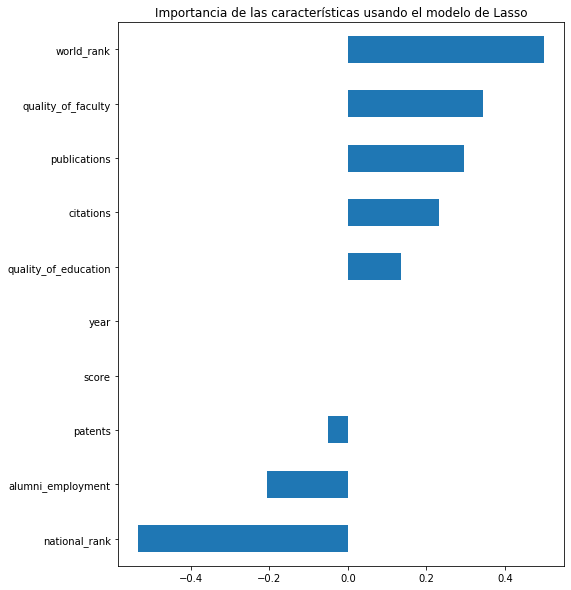

In [31]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")

 Aqui solamente tomamos todas las caracteristicas menos year y score 